# Pooling-imputation performance from real bead chip data with high density markers

Performs pooling simulation and imputation on data from the chromosome 20 of 1000GP.
Markers have been chosen as the intersection between the real bead chip Illumina Infinium OmniExpress2.5 - 8 Kit
 (https://support.illumina.com/array/array_kits/humanomniexpress2.5-8-beadchip-kit/downloads.html) 
 and the chr20 1000GP data. The samples are randomly assigned to the reference panel or the study population.

Apply pooling simulation on this data, and imputation (run parallel execution): 
**pool and impute bead chip markers only, compute metrics and plot statistics** 
Phasing + imputation are run **modelscale=7.0** parameter for trying to account 
for dependency between clustered genotypes

In [1]:
import os

try:
    os.mkdir('/home/camille/PoolImpHuman/data/20200718')
except FileExistsError:
    pass
os.chdir('/home/camille/PoolImpHuman/data/20200718')

In [2]:
print('Configure directory')
%sx ln -s ~/1000Genomes/scripts/VCFPooling/python/omniexpress_20200718.ipynb ./
%sx ln -s ../omniexpress8/InfiniumOmniExpress-chr20-CHROM-POS.txt ./
%sx ln -s /home/camille/PoolImpHuman/data/20200709/IMP.chr20.pooled.snps.gl.vcf.gz
%sx ln -s /home/camille/PoolImpHuman/data/20200709/IMP.chr20.snps.gt.vcf.gz 
%sx ln -s /home/camille/PoolImpHuman/data/20200709/REF.chr20.snps.gt.vcf.gz

Configure directory


[]

### Prepare experimental VCF file

IMP and REF files are identical to 20200709 (imputation with default parameters)

In [3]:
print('Impute missing genotypes in the pooled file')
%sx ln -s /home/camille/PoolImpHuman/bin/bash-scripts/beagle_pipeline_modelscale7.sh
%sx bash beagle_pipeline_modelscale7.sh

Impute missing genotypes in the pooled file


['Contigs in the reference file',
 '.................................................................................',
 'Chromosome  20    Startpos = 61651    Endpos = 62947458',
 '',
 '',
 'Check FORMAT field in files for imputation',
 '.................................................................................',
 'FORMAT in reference panel:  GT',
 'FORMAT in target:  GL',
 '',
 '',
 'Check number of samples and number of markers in files for imputation',
 '.................................................................................',
 'reference:',
 '2264',
 '',
 'target:',
 '240',
 '',
 '',
 'Phase reference and target with BEAGLE',
 '.................................................................................',
 'Beagle .jar file used at: /home/camille/1000Genomes/scripts/beagle.11Mar19.69c.jar',
 '',
 'FORMAT in the phased ref file: GT',
 'beagle.11Mar19.69c.jar (version 4.1)',
 'Copyright (C) 2014-2015 Brian L. Browning',
 'Enter "java -jar beagle.11Mar19.69c.jar

In [4]:
print('Plotting results with bcftools stats')
%sx deactivate
# bcftools stats needs python 2.7
%sx ln -s /home/camille/PoolImpHuman/data/20200709/study.population
%sx bcftools stats --af-bins 0.01,0.02,0.04,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.98 --collapse snps -S study.population IMP.chr20.pooled.imputed.vcf.gz IMP.chr20.snps.gt.vcf.gz > filestats.vchk
%sx plot-vcfstats -p bcftoolstats -s filestats.vchk

Plotting results with bcftools stats


['Parsing bcftools stats output: filestats.vchk',
 'Sanity check failed: was this file generated by bcftools stats? at /usr/bin/plot-vcfstats line 99.',
 '\tmain::error("Sanity check failed: was this file generated by bcftools stats?") called at /usr/bin/plot-vcfstats line 585',
 '\tmain::parse_vcfstats1(HASH(0x55c947fa0b78), 0) called at /usr/bin/plot-vcfstats line 294',
 '\tmain::parse_vcfstats(HASH(0x55c947fa0b78)) called at /usr/bin/plot-vcfstats line 47']

### Compute results with customized metrics

In [5]:
paths = {'beaglegt': {
    'true': '/home/camille/PoolImpHuman/data/20200718/IMP.chr20.snps.gt.vcf.gz',
    'imputed': '/home/camille/PoolImpHuman/data/20200718/IMP.chr20.pooled.imputed.vcf.gz'},
         'beaglegl': {
     'true': '/home/camille/PoolImpHuman/data/20200718/IMP.chr20.snps.gl.vcf.gz',
     'imputed': '/home/camille/PoolImpHuman/data/20200718/IMP.chr20.pooled.imputed.vcf.gz'},
}

In [6]:
import subprocess

convertgtgl = True
if convertgtgl:
    cmd = 'bash ~/PoolImpHuman/bin/bash-scripts/gt_to_gl.sh {} {}'.format(paths['beaglegt']['true'], paths['beaglegl']['true'])
    subprocess.run(cmd, shell=True,)

In [8]:
import pandas as pd
from scripts.VCFPooling.poolSNPs.metrics import quality

['/home/camille/PoolImpHuman/data/20200718', '/home/camille/1000Genomes', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages', '/home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages/setuptools-40.8.0-py3.6.egg', '/home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages/pip-19.0.3-py3.6.egg', '/home/camille/1000Genomes/venv3.6/lib/python3.6/site-packages/IPython/extensions', '/home/camille/.ipython', '/usr/bin/pycharm/plugins/python/helpers/pydev', '/usr/bin/pycharm/plugins/python/helpers-pro/jupyter_debug']


In [9]:
qbeaglegt = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')

In [10]:
qbeaglegl = quality.QualityGL(paths['beaglegl']['true'], paths['beaglegl']['imputed'], 0, idx='id')
messbeagle = qbeaglegl.cross_entropy

In [11]:
#qbeaglegl = quality.QualityGT(*paths['beaglegt'].values(), 0, idx='id')
tabbeaglegl = pd.concat([qbeaglegt.concordance(),
                       qbeaglegt.trueobj.af_info,
                       qbeaglegt.pearsoncorrelation(),
                       qbeaglegt.precision,
                       qbeaglegt.accuracy,
                       qbeaglegt.recall,
                       qbeaglegt.f1_score,
                        qbeaglegl.cross_entropy], axis=1)
dosbeaglegl = qbeaglegt.alleledosage()


In [12]:
tabbeaglegl.head()

,concordance,af_info,r_squared,precision_score,accuracy_score,recall_score,f1_score,cross_entropy
variants,,,,,,,,
rs76553454,1.000000,0.005791,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
rs6076506,0.770833,0.130990,0.081230,0.763365,0.779167,0.779167,0.694992,1.104167
rs6139074,0.525000,0.218251,NaN,0.335434,0.579167,0.579167,0.424824,2.104167
rs1418258,0.483333,0.439497,0.005586,0.385064,0.500000,0.500000,0.390539,2.500000
rs6086616,0.395833,0.571286,0.011508,0.590908,0.420833,0.420833,0.315611,2.895833


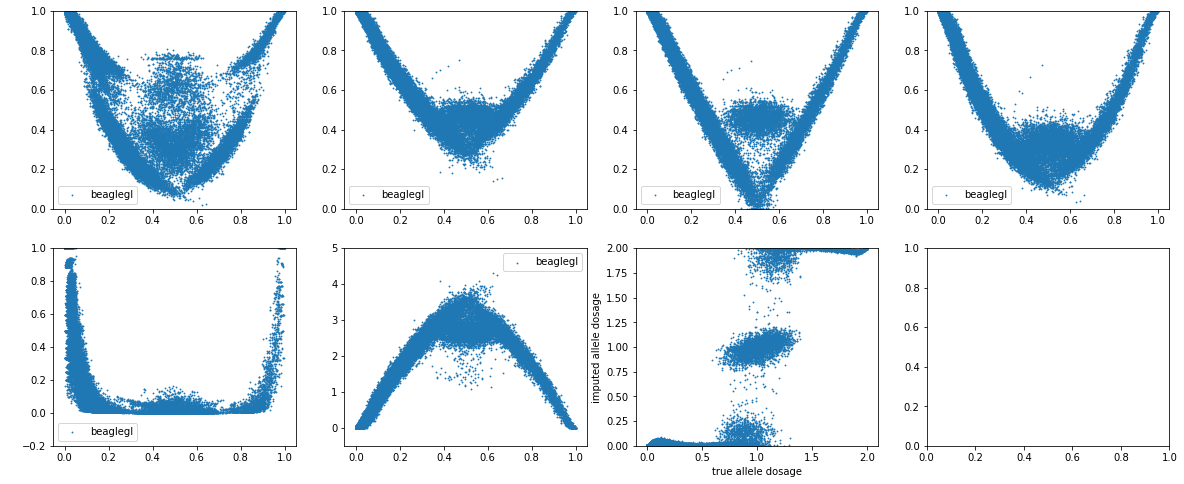

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5*4, 4*2]
fig, axes = plt.subplots(2, 4)

tabbeaglegl.plot.scatter('af_info', 'precision_score', ax=axes[0, 0], s=0.7, label='beaglegl')
axes[0, 0].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'accuracy_score', ax=axes[0, 1], s=0.7, label='beaglegl')
axes[0, 1].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'concordance', ax=axes[0, 2], s=0.7, label='beaglegl')
axes[0, 2].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'f1_score', ax=axes[0, 3], s=0.7, label='beaglegl')
axes[0, 3].set_ylim(0.0, 1.0)
tabbeaglegl.plot.scatter('af_info', 'r_squared', ax=axes[1, 0], s=0.7, label='beaglegl')
axes[1, 0].set_ylim(-0.2, 1.0)
tabbeaglegl.plot.scatter('af_info', 'cross_entropy', ax=axes[1, 1], s=0.7, label='beaglegl')
axes[1, 1].set_ylim(-0.5, 5.0)
axes[1, 2].scatter(dosbeaglegl[0], dosbeaglegl[1], s=0.7, label='beaglegl')
axes[1, 2].set_xlabel('true allele dosage')
axes[1, 2].set_ylabel('imputed allele dosage')
axes[1, 2].set_ylim(0.0, 2.0)

for ax in axes.flatten()[:-2]:
    # cast color to white 'w' if dark background
    ax.set_xlabel('true alternate allele frequency', color='w')
    ax.set_ylabel(ax.get_ylabel(), color='w')
plt.savefig(os.path.join(os.path.dirname(paths['beaglegt']['imputed']), 'imputation_quality_gtgl.png'))
plt.show()